<a href="https://colab.research.google.com/github/avilaJorge/CSE253_FinalProject/blob/master/DeepFakeDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install gdown

In [0]:
# imports pytorch
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Numpy, Matplotlib, and PIL
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# general imports
import gdown
import pathlib
import pprint
import tarfile

download = False 

faces_hq = 'https://drive.google.com/uc?id=15UDKEI5kEl_BHiBqmjmfaho2JCw267oU'
faces_hq = 'https://drive.google.com/uc?id=1AqbGw82ueBP3fNNVCbXZgOPPFsh2uNXm'
faces_hq = 'https://drive.google.com/uc?id=1-bvJ5rN81ZUPGi8a9LEiB-K_QNwyhelh'
faces_hq = 'https://drive.google.com/uc?id=1V2EnCH3ExXEy-8Eu_JhV4RUTh6tKSRUy'
faces_hq = 'https://drive.google.com/uc?id=1fBbXsaVvfgDtWi5y2zl9ZoZiO46lqlD5'
faces_hq = 'https://drive.google.com/uc?id=1vyEAtaZ9bSwPhHLKObaXnVMu-9rHywX6'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
if download:
    gdown.download(faces_hq, 'hq_faces.tar.gz', quiet=False)
    !tar -xvzf ./hq_faces.tar.gz

In [28]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Mar  9 04:10:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    28W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Source: [Efficient Radial Profile](https://stackoverflow.com/questions/21242011/most-efficient-way-to-calculate-radial-profile)


---


***numpy.bincount***

`numpy.bincount(x, weights=None, minlength=0)`

Count number of occurrences of each value in array of non-negative ints.

> The number of bins (of size 1) is one larger than the largest value in x. If minlength is specified, there will be at least this number of bins in the output array (though it will be longer if necessary, depending on the contents of x). Each bin gives the number of occurrences of its index value in x. If weights is specified the input array is weighted by it, i.e. if a value n is found at position i, `out[n] += weight[i]` instead of `out[n] += 1`.

---



In [0]:
def np_radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    y, x = torch.from_numpy(y).to(device), torch.from_numpy(x).to(device)

    r = torch.stack((torch.sub(x, center[0]), torch.sub(y, center[1])), dim=2).float()
    r = torch.norm(r, dim=2).long()
    tbin = torch.bincount(r.view(r.numel()), data.view(data.numel()))
    nr   = torch.bincount(r.view(r.numel()))

    radialprofile = torch.div(tbin, nr)
    return radialprofile

def np_magnitude_spectrum(img):
    f = np.fft.fft2(img2)
    f = np.fft.fftshift(f)
    return 20*np.log(np.abs(f))

def magnitude_spectrum(img):
    t_img =  torch.rfft(img, signal_ndim=2, onesided=False) * 255
    shifts = (int(t_img.size()[0]/2), int(t_img.size()[1]/2))
    t_img = torch.roll(t_img, shifts=shifts, dims=(0, 1))
    return 20*torch.log(torch.norm(t_img, dim=2))


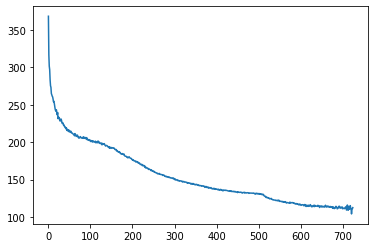

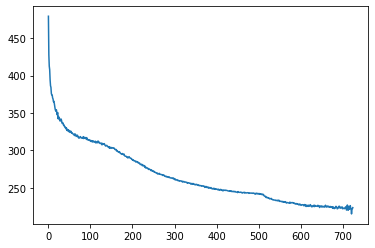

In [33]:
img2 = Image.open('./Frequency/Faces-HQ/celebA-HQ_10K/0.jpg')
# display(img2)
img2 = img2.convert('L')
img2.save('greyscale.png')

mag_spectrum = np_magnitude_spectrum(img2)
rad2 = np_radial_profile(mag_spectrum, center=(mag_spectrum.shape[0]/2, mag_spectrum.shape[1]/2))
plt.plot(rad2)
plt.show()

t_img = torch.from_numpy(np.asarray(img2)).squeeze(0).float().to(device)
ms = magnitude_spectrum(t_img)
rad2 = radial_profile(ms, center=(ms.shape[0]/2, ms.shape[1]/2))
plt.plot(rad2.cpu())
plt.show()